In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import sklearn
import scipy
import scipy.sparse as spa
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
np.set_printoptions(threshold=999)

# Construct the sample network given in the paper

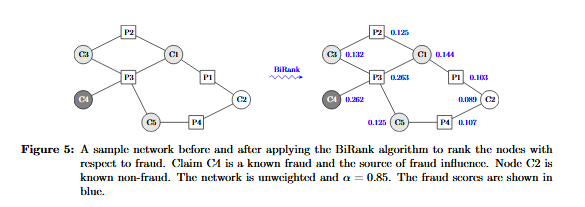

In [2]:
from networkx.algorithms import bipartite
G = nx.Graph()
# add nodes from any iterable container, such as a list

# Add Involved Parties Nodes
G.add_nodes_from([
    ("P1", {"claims": 26, "fraudulent": 6, "non-fraudulent": 11}),
    ("P2", {"claims": 501, "fraudulent": 6, "non-fraudulent": 4}),
    ("P3", {"claims": 11, "fraudulent": 1, "non-fraudulent": 3}),
    ("P4", {"claims": 34, "fraudulent": 0, "non-fraudulent": 5})
], bipartite = 0) 

# can add node attributes if your container yields 2-tuples of the form (node, node_attribute_dict)

# Add Claims Nodes 
G.add_nodes_from([
    ("C1", {"label": "unknown"}),
    ("C2", {"label": "no_fraud"}),
    ("C3", {"label": "unknown"}),
    ("C4", {"label": "fraud"}),
    ("C5", {"label": "unknown"})
], bipartite = 1) # Add node-type of Involved Parties

# add edges by adding a list of edges, or any ebunch of edges
# ebunch is iterable container of edge-tuples, 2-tuple/3-tuple nodes
# (node1, node2)/(node1, node2, edge_attribute_dict)

# Add edges

G.add_weighted_edges_from([
    ("P1", "C2", 1),
    ("P1", "C1", 1),
    ("C1", "P3", 1),
    ("P3", "C4", 1),
    ("P3", "C3", 1),
    ("C3", "P2", 1),
    ("P2", "C1", 1),
    ("P3", "C5", 1),
    ("C5", "P4", 1),
    ("P4", "C2", 1),
    ("C2", "P1", 1)
])

# Birank - Normalize Edgeweights
Birank normalizes the edge weights by the degree of the two adjacent nodes:
$$
Edge(u,v) = \frac{1}{\sqrt{deg(u)}\sqrt{deg(v)}}
$$

The effect is that the edges between nodes of high degrees, i.e. edge('P3, 'C1') = 0.2887 is lower than the nodes between nodes of lower degrees i.e. edge('P3', 'C3') = 0.356.  
During the calculation of the birank scores the updates will taken into account. So `Workshops`, `Claim Handler` and other `Involved Parties` with high degrees nodes's contribution to the birank score will be dampened.

In [3]:
for u, v, d in G.edges(data=True):
    d['weight'] = d['weight'] / np.sqrt(G.degree[u] * G.degree[v])
    print( (u, G.degree[u], v, G.degree[v]), d)

('P1', 2, 'C2', 2) {'weight': 0.5}
('P1', 2, 'C1', 3) {'weight': 0.4082482904638631}
('P2', 2, 'C3', 2) {'weight': 0.5}
('P2', 2, 'C1', 3) {'weight': 0.4082482904638631}
('P3', 4, 'C1', 3) {'weight': 0.2886751345948129}
('P3', 4, 'C4', 1) {'weight': 0.5}
('P3', 4, 'C3', 2) {'weight': 0.35355339059327373}
('P3', 4, 'C5', 2) {'weight': 0.35355339059327373}
('P4', 2, 'C5', 2) {'weight': 0.5}
('P4', 2, 'C2', 2) {'weight': 0.5}


$$
claimsbirank_j = \alpha \sum_{i=1}^{|P|} \frac{1}{\sqrt{deg(u)}\sqrt{deg(v)}}p_i + (1-\alpha)c^0_j,  
partiesbirank_i = \beta \sum_{j=1}^{|C|} \frac{1}{\sqrt{deg(u)}\sqrt{deg(v)}}c_j
$$

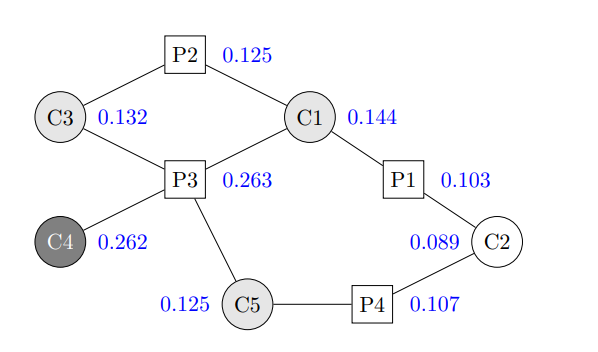

In [4]:
G.edges[('P4', 'C2')]

{'weight': 0.5}

In [5]:
print(bipartite.is_bipartite(G))
c = bipartite.color(G)
nodes = list(bipartite.color(G).keys())
# https://stackoverflow.com/questions/13517614/draw-different-color-for-nodes-in-networkx-based-on-their-node-value
color_map = {
    0: 'lightgreen',
    1: 'lightblue'
}
values = [color_map.get(value) for value in c.values()]
values

True


['lightblue',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue']

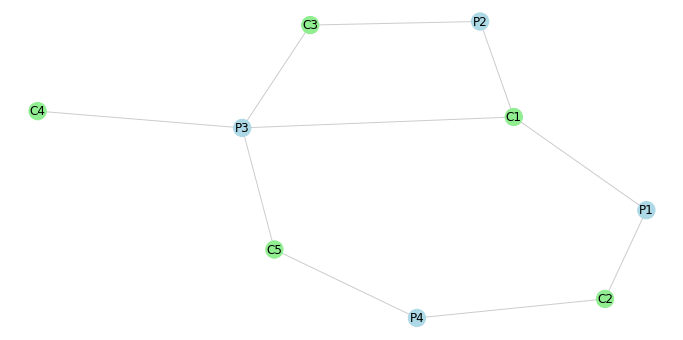

In [6]:
import networkx as nx
from networkx.algorithms import bipartite
# https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt
plt.figure(figsize=(12,6))
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color = values)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.show()

Export it as an Edgelist so that we can use calculate birank scores

In [7]:
edgelist_df_small_example = bipartite.edgelist.write_edgelist(G, 'edgelist_df_small_example', data=False)
edgelist_df_small_example

In [8]:
edgelist_df = pd.read_csv("edgelist_df_small_example", names=['Parties', 'Claims'], delim_whitespace=True)
edgelist_df

,Parties,Claims
0,P1,C2
1,P1,C1
2,P2,C3
3,P2,C1
4,P3,C1
5,P3,C4
6,P3,C3
7,P3,C5
8,P4,C5
9,P4,C2


In [9]:
G.edges(data=True)

EdgeDataView([('P1', 'C2', {'weight': 0.5}), ('P1', 'C1', {'weight': 0.4082482904638631}), ('P2', 'C3', {'weight': 0.5}), ('P2', 'C1', {'weight': 0.4082482904638631}), ('P3', 'C1', {'weight': 0.2886751345948129}), ('P3', 'C4', {'weight': 0.5}), ('P3', 'C3', {'weight': 0.35355339059327373}), ('P3', 'C5', {'weight': 0.35355339059327373}), ('P4', 'C5', {'weight': 0.5}), ('P4', 'C2', {'weight': 0.5})])

In [10]:
#G.edges[('P4', 'C2')]
G.edges[('P1', 'C2')]['weight']

0.5

In [11]:
def get_edgeweight(G, x):
    '''
    Returns the edge weight of a weighted graph
    
    Inputs:
        G::nx.Graph: NetworkX Graph with edge_weight attributes set to 'weight'
        x::pd.DataFrame: Edgelist DataFrame with first column the Source, second column the Dest
        
    Returns:
        pd.Series of the edgeweights between col1, col2 for every row in the DataFrame
    '''
    u, v = x[0], x[1]
    return G.edges[(u, v)]['weight']

edgelist_df['Weight'] = edgelist_df.apply(lambda x: get_edgeweight(G, x), axis=1)
edgelist_df

,Parties,Claims,Weight
0,P1,C2,0.500000
1,P1,C1,0.408248
2,P2,C3,0.500000
3,P2,C1,0.408248
4,P3,C1,0.288675
5,P3,C4,0.500000
6,P3,C3,0.353553
7,P3,C5,0.353553
8,P4,C5,0.500000
9,P4,C2,0.500000


# 1. Birank Algorithm

In [12]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse as spa


class Bipartite:
    """
    Class for handling bipartite networks using scipy's sparse matrix
    """
    def __init__(self):
        pass

    def set_edgelist(self, df, parties_col, claims_col, weight_col=None):
        """
        Method to set the edgelist.

        Input:
            df::pandas.DataFrame: the edgelist with at least two columns
            parties_col::string: column of the edgelist dataframe for Involved Parties nodes
            claims_col::string: column of the edgelist dataframe for Claims nodes
            weight_col::string: column of the edgelist dataframe for edge weights

        The edgelist should be represented by a dataframe.
        The dataframe needs at least two columns for the Involed Parties nodes and
        Claims nodes. An optional column can carry the edge weight.
        You need to specify the columns in the method parameters.
        """
        self.df = df
        self.parties_col = parties_col
        self.claims_col = claims_col
        self.weight_col = weight_col

        self._index_nodes()
        self._generate_adj()
    
    def generate_degree(self):
        """
        This method returns the degree of nodes in the bipartite network
        """
        parties_df = self.df.groupby(self.parties_col)[self.claims_col].nunique()
        parties_df = parties_df.to_frame(name='degree').reset_index()
        claims_df = self.df.groupby(self.claims_col)[self.parties_col].nunique()
        claims_df = claims_df.to_frame(name='degree').reset_index()
        return parties_df, claims_df
    
    def _index_nodes(self):
        """
        Representing the network with adjacency matrix requires indexing the parties
        and claims nodes
        """
        
        self.parties_ids = pd.DataFrame(
            self.df[self.parties_col].unique(),
            columns=[self.parties_col]
        ).reset_index()
        self.parties_ids = self.parties_ids.rename(columns={'index': 'parties_index'})
        
        self.claims_ids = pd.DataFrame(
            self.df[self.claims_col].unique(),
            columns=[self.claims_col]
        ).reset_index()
        self.claims_ids = self.claims_ids.rename(columns={'index': 'claims_index'})

        self.df = self.df.merge(self.parties_ids, on=self.parties_col)
        self.df = self.df.merge(self.claims_ids, on=self.claims_col)

    def _generate_adj(self):
        """
        Generating the adjacency matrix for the birparite network.
        The matrix has dimension: D * P where D is the number of top nodes
        and P is the number of bottom nodes
        """
        if self.weight_col is None:
            # set weight to 1 if weight column is not present
            weight = np.ones(len(self.df))
        else:
            weight = self.df[self.weight_col]
        self.W = spa.coo_matrix(
            (
                weight,
                (self.df['parties_index'].values, self.df['claims_index'].values)
            )
        )


    def generate_birank(self, normalizer='BiRank',
    alpha=0.85, beta=1, max_iter=500, tol=1.0e-5, prior=[], verbose=False):
        """
        Calculate the Fraud Score of bipartite networks directly.
        See paper https://arxiv.org/pdf/2009.08313.pdf
        for details.
        HITS, CoHITS, BGRM, BiRank Normalizer's implemented
        See paper https://ieeexplore.ieee.org/abstract/document/7572089/
        for details.

        Input:
            W::scipy's sparse matrix:Adjacency matrix of the bipartite network P*C
            normalizer::string:Choose which normalizer to use, see the paper for details
            alpha, beta::float:Damping factors for the rows and columns
            max_iter::int:Maximum iteration times. Set max_iter to 0 or 1 to return the prior_vector and prior
            tol::float:Error tolerance to check convergence 
            prior::list: List of integers of known fradulent claims, e.g. Claim1, Claim3 Fraudulent -> [1,3]
            p: query vector for BiRank algorithm will then be arr, 1 at index prior-1, 0 otherwise, e.g. [1,0,1,0,0]
            verbose::boolean:If print iteration information

        Output:
             p, c::numpy.ndarray:BiRank scores for Parties and Claims
        """
        W = self.W
        df = self.df
        W = W.astype('float', copy=False)
        WT = W.T

        Kp = np.array(W.sum(axis=1)).flatten()
        Kc = np.array(W.sum(axis=0)).flatten()

        # avoid divided by zero issue
        Kp[np.where(Kp==0)] += 1
        Kc[np.where(Kc==0)] += 1

        # Normalizing the W weight matrix
        Kp_ = spa.diags(1/Kp)
        Kc_ = spa.diags(1/Kc)
        if normalizer == 'HITS':
            Sc = WT
            Sp = W
        elif normalizer == 'CoHITS':
            Sc = WT.dot(Kp_)
            Sp = W.dot(Kc_)
        elif normalizer == 'BGRM':
            Sc = Kc_.dot(WT).dot(Kp_)
            Sp = Sc.T
        elif normalizer == 'BiRank':
            Kp_bi = spa.diags(1/np.lib.scimath.sqrt(Kp))
            Kc_bi = spa.diags(1/np.lib.scimath.sqrt(Kc))
            Sc = Kc_bi.dot(WT).dot(Kp_bi)
            Sp = Sc.T
        # Sc and Sp are symmetric normalized weight matrix

        # Generate prior vector

        claims_col = self.claims_col
        claims_id = self.claims_ids.copy()
        claims_id['prior_from_prior'] = np.where(claims_id[claims_col].isin(prior), 1, 0)

        mask = claims_id[claims_col].isin(prior)
        prior_df_temp = claims_id[mask]

        prior_vector = np.zeros(len(claims_id))
        indices_to_put_prior = prior_df_temp['claims_index'].values
        np.put( prior_vector, indices_to_put_prior, np.ones(len(indices_to_put_prior)) )
        print( "No. of known prior fraudulent flags:", sum(prior_vector), "Length of prior_vector:", len(prior_vector) )

        claims_id['prior_from_setting_indices'] = prior_vector

        mask = claims_id['prior_from_setting_indices'] != claims_id['prior_from_prior']
        if claims_id[mask].shape[0] > 0:
            print("Prior vector not correctly set!")
            return prior_vector, prior

        parties_id = self.parties_ids.copy()
        # p: Parties (0 vector), c: Claims (prior)
        p0 = np.zeros(Kp_.shape[0])
        p_last = p0.copy()
        c0 = prior_vector
        c_last = c0.copy()

        if max_iter == 0 or max_iter == 1:
            print('Earning Stopping Warning: max_iter is {max_iter}'.format(max_iter=max_iter))
            c = c0
            p = p0
            return p, c

        for i in range(max_iter):
            c = alpha * (Sc.dot(p_last)) + (1-alpha) * c0
            p = beta * (Sp.dot(c_last)) + (1-beta) * p0

            if normalizer == 'HITS':
                c = c / c.sum()
                p = p / p.sum()

            err_c = np.absolute(c - c_last).sum()
            err_p = np.absolute(p - p_last).sum()
            if verbose:
                print(
                    "Iteration : {}; top error: {}; bottom error: {}".format(
                        i, err_p, err_c
                    )
                )
            if err_c < tol and err_p < tol:
                break
            p_last = p
            c_last = c
        parties_id['birank_score'] = p
        claims_id['birank_score'] = c
        return (parties_id[[self.parties_col, 'birank_score']],
                claims_id[[self.claims_col, 'birank_score']])

In [13]:
bn = Bipartite()
bn.set_edgelist(edgelist_df,  parties_col='Parties', claims_col='Claims')

prior = ["C4"]
parties_birank, claims_birank = bn.generate_birank(normalizer="BiRank", alpha=0.85, beta=1, prior=prior, max_iter=500, tol=1.0e-4, verbose=False)
claims_birank

No. of known prior fraudulent flags: 1.0 Length of prior_vector: 5


,Claims,birank_score
0,C2,0.089363
1,C1,0.143676
2,C3,0.132049
3,C4,0.261810
4,C5,0.124508


In [14]:
parties_birank

,Parties,birank_score
0,P1,0.103355
1,P2,0.124699
2,P3,0.263114
3,P4,0.106954


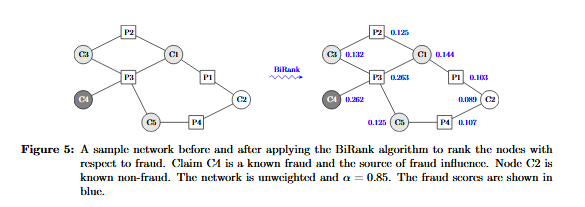

## 1.1 Checking the correctness of birank_scores

Notation:  
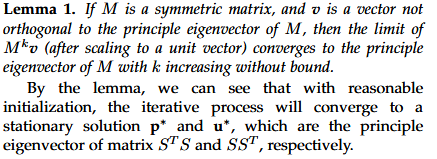  
**p*** are the principle eigenvector of ($S^{T}S$) = `claims_birank`  
**u***are the principle eigenvector of ($SS^{T}$) = `parties_birank`   

In [15]:
p = claims_birank['birank_score'].values # p vector is the principal eigenvecctor of matrix S^T*S
u = parties_birank['birank_score'].values

W = bn.W.astype('float', copy=False)
WT = W.T

Ku = scipy.array(W.sum(axis=1)).flatten()
Kp = scipy.array(W.sum(axis=0)).flatten()

# avoid divided by zero issue
#Ku[np.where(Ku==0)] += 1
#Kp[np.where(Kp==0)] += 1

# Normalizing the W weight matrix
Ku_ = spa.diags(1/Ku)
Kp_ = spa.diags(1/Kp)

# BiRank Normalization
Ku_bi = spa.diags(1/scipy.sqrt(Ku))
Kp_bi = spa.diags(1/scipy.sqrt(Kp))
Sp = Kp_bi.dot(WT).dot(Ku_bi) # S^T
Su = Sp.T # S

ST_S = Sp.dot(Su)
S_ST = Su.dot(Sp)
print(ST_S.shape, S_ST.shape)

(5, 5) (4, 4)


<ipython-input-15-0fe36d831195>:7: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  Ku = scipy.array(W.sum(axis=1)).flatten()
<ipython-input-15-0fe36d831195>:8: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  Kp = scipy.array(W.sum(axis=0)).flatten()
<ipython-input-15-0fe36d831195>:19: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  Ku_bi = spa.diags(1/scipy.sqrt(Ku))
<ipython-input-15-0fe36d831195>:20: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  Kp_bi = spa.diags(1/scipy.sqrt(Kp))


We define $$M: \alpha\beta[S^TS]$$ and by theorem 1: M's eigenvalues are bounded by $$[-\alpha\beta, \alpha\beta]$$  

Recall:  
p is principal eigenvector of ST_S (Sc @ Sp),  
u is principal eigenvector of SS_T (Sp @ Sc)

$$
Ax = \lambda x
$$
is the form 
$$
p \cdot S^{T}S = \lambda \cdot S^{T}S
$$
In our case since we specified $\alpha=0.85, \beta=1$, the bound is $[-0.85, 0.85]$

In [16]:
eigenvalues, eigenvectors = np.linalg.eig(0.85 * S_ST.todense())
print(eigenvalues)
print(np.min(eigenvalues), np.max(eigenvalues))

[0.85  0.068 0.259 0.452]
0.06835340246252992 0.8499999999999995


In [17]:
eigenvalues, eigenvectors = np.linalg.eig(0.85 * ST_S.todense())
print(eigenvalues)
print(np.min(eigenvalues), np.max(eigenvalues))

[8.500e-01 4.520e-01 2.588e-01 1.035e-17 6.835e-02]
1.0349510324812541e-17 0.8499999999999988


This is equivalent to checking if the $S$ symmetric normalized matrix is a stochastic matrix, whose properties has maximum absolute eigenvalues 1, hence by definition M $\in[-\alpha\beta, \alpha\beta]$

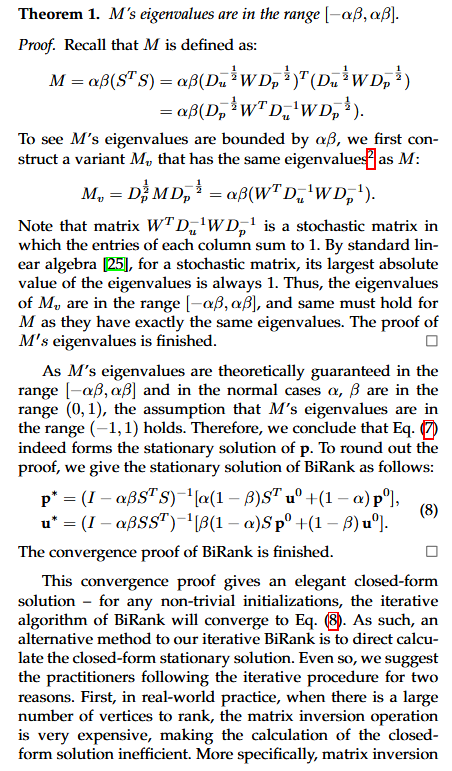

In [18]:
prior_vector = np.array([0,0,0,1,0])
prior_vector

array([0, 0, 0, 1, 0])

In [19]:
claims = np.linalg.inv( np.identity(ST_S.todense().shape[0]) - 0.85 * ST_S ) * ( 0.15 * prior_vector.reshape((5,1)) )
claims.flatten()

matrix([[0.089, 0.144, 0.132, 0.262, 0.125]])

In [20]:
claims_birank['birank_score'].values

array([0.089, 0.144, 0.132, 0.262, 0.125])

In [21]:
parties = np.linalg.inv( np.identity(S_ST.todense().shape[0]) - 0.85 * S_ST) * (0.15 * Su.todense() * prior_vector.reshape((5,1)))
parties.flatten()

matrix([[0.103, 0.125, 0.263, 0.107]])

In [22]:
parties_birank['birank_score'].values

array([0.103, 0.125, 0.263, 0.107])

## 1.2 A Note on Sparse Coordinate Matrix

$$
\text{claims_birank} = \alpha Wp + (1-\alpha) c^0,  
\text{parties_birank} = W^T c
$$
**W** is the symmetrically normalized weight matrix  
**c, p** are randomly initialized vector to hot start  
**c^0** is vector of know fraudulent claims (investigated and found to be fraudulent)  
$\alpha$ controls the trade-off between importance of network structure and query vector of known fraudulent claims

Higher $\alpha$ : More weightage placed on network structure, less weightage on prior information of known fraudulent claim  
Lower $\alpha$ : Less weightage placed on network structure, more weightage on prior information of known fraudulent claim

In [23]:
from networkx.algorithms import bipartite
print(bipartite.is_bipartite(G))
rows = ['P1', 'P2', 'P3', 'P4']
cols = ['C1', 'C2', 'C3', 'C4', 'C5']
W = bipartite.matrix.biadjacency_matrix(G, row_order = rows, column_order = cols)
W.todense()

True


matrix([[0.408, 0.5  , 0.   , 0.   , 0.   ],
        [0.408, 0.   , 0.5  , 0.   , 0.   ],
        [0.289, 0.   , 0.354, 0.5  , 0.354],
        [0.   , 0.5  , 0.   , 0.   , 0.5  ]])

Constructing the **W** unnormalized weight matrix to parse into the birank algorithm

In [24]:
bn.df['parties_index'].values # i

array([0, 3, 0, 1, 2, 1, 2, 2, 2, 3], dtype=int64)

In [25]:
bn.df['claims_index'].values # j

array([0, 0, 1, 1, 1, 2, 2, 3, 4, 4], dtype=int64)

In [26]:
n = len(bn.df['parties_index'].values)
weight = np.ones(n) # data
weight

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

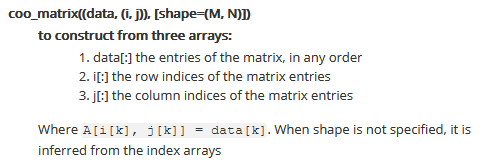

In [27]:
import scipy.sparse as spa
W = spa.coo_matrix(
            (
                weight,
                (bn.df['parties_index'].values, bn.df['claims_index'].values)
            )
        )
W.todense()

matrix([[1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1.]])

Notice this is different from the adjacency matrix returned by NetworkX.  
This is because the columns in the W matrix is ['C2', 'C1', 'C3', 'C4', 'C5'], in the order of the `Claims` column in the given `edgelist_df`

In [28]:
from networkx.algorithms import bipartite
print(bipartite.is_bipartite(G))
rows = ['P1', 'P2', 'P3', 'P4']
cols = ['C2', 'C1', 'C3', 'C4', 'C5']
W = bipartite.matrix.biadjacency_matrix(G, row_order = rows, column_order = cols)
W.todense()

True


matrix([[0.5  , 0.408, 0.   , 0.   , 0.   ],
        [0.   , 0.408, 0.5  , 0.   , 0.   ],
        [0.   , 0.289, 0.354, 0.5  , 0.354],
        [0.5  , 0.   , 0.   , 0.   , 0.5  ]])

This is equal now

## 1.3 A Note on prior vector

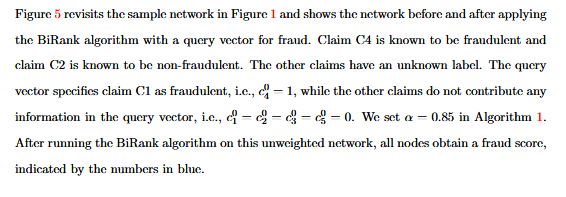

In order words, the prior vector will be:
prior = [0, 0, 0, 1, 0]  
prior[3] == 1 because 'C4' is known to be fraudulent, the rest == 0

In [29]:
prior = ["C4"]
# Generate prior vector
temp_df = pd.DataFrame(
    bn.df['Claims'].unique(),
    columns=['Claims']
).reset_index()

temp_df['prior'] = np.where(temp_df['Claims'].isin(prior), 1, 0)
temp_df

,index,Claims,prior
0,0,C2,0
1,1,C1,0
2,2,C3,0
3,3,C4,1
4,4,C5,0


In [30]:
prior_vector = temp_df['prior'].values
prior_vector

array([0, 0, 0, 1, 0])

## 1.4 A Note on why we use Birank instead of PageRank
`PageRank` scores nodes in a network to bring out nodes that are important in the network, we personalize `PageRank` to bring out the nodes that are important to a set of specific nodes, which in our perspective will be the known Fraduluent Claims. The resulting scores are then personalized towards these known fraudulent nodes, to reflect a preference for this nodes based on the homophilic nature of the network.

When calculating node centrality measures in bipartite networks, a common approach is to apply `PageRank` on the one-mode projection of the network. Basically for two sets $U$ and $P$, while there won't be any edges within nodes in $U$, but if two vertices in $U$ are connected via some node in $P$ as in our case, a projection onto $U$ will cause the information of the intermediate node in $P$ that causes $u_1$ and $u_2$ to be connected to be lost. You will lose the information on the intermediate node that connects $u_1$ and $u_2$ and distort the network topology.  

For better node ranking on bipartite networks wrt to our network structure, as is our use case with `Claims` and `Parties`, it is preferable to use a ranking algorithm that fully accounts for the topology of both modes of the network.

In [31]:
bn = Bipartite()
# prior vector uses only known fradulent claims as query vector in BiRank
bn.set_edgelist(edgelist_df,  parties_col='Parties', claims_col='Claims')
# prior vector must be a list of the Claims ID known to be fraudulent
prior=["C4"]
parties_birank, claims_birank = bn.generate_birank(normalizer="BiRank", alpha=0.85, beta=1, max_iter=200, tol=1.0e-4, prior=prior, verbose=False)
#β = 1, since only the network structure matters in the absence of the query vector.
claims_birank

No. of known prior fraudulent flags: 1.0 Length of prior_vector: 5


,Claims,birank_score
0,C2,0.089363
1,C1,0.143676
2,C3,0.132049
3,C4,0.261810
4,C5,0.124508


In [32]:
new_cols = {"Claims": "node", "Parties": "node"}
df = parties_birank.rename(columns=new_cols).append(claims_birank.rename(columns=new_cols)).reset_index(drop=True)
df

,node,birank_score
0,P1,0.103355
1,P2,0.124699
2,P3,0.263114
3,P4,0.106954
4,C2,0.089363
5,C1,0.143676
6,C3,0.132049
7,C4,0.261810
8,C5,0.124508


## Feature Engineering

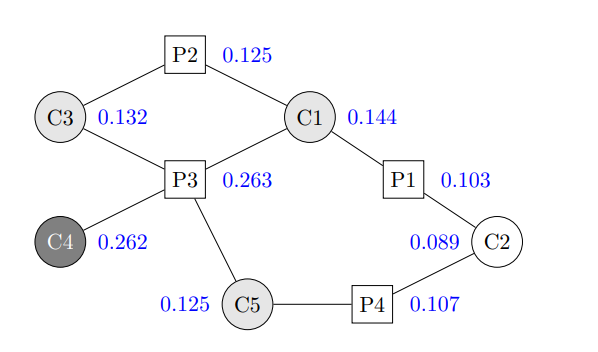

In [33]:
def neighborhood(G, node, n):
    '''
    https://stackoverflow.com/questions/22742754/finding-the-n-degree-neighborhood-of-a-node
    Returns a list of nodes in the n-order neighborhood of
    '''
    path_lengths = nx.single_source_dijkstra_path_length(G, node, weight=None)
    return [node for node, length in path_lengths.items()
                    if length == n]

def generate_n1_q1(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_q1 = temp_df['birank_score'].quantile(0.25)
    return n1_q1

def generate_n1_q1(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_q1 = temp_df['birank_score'].quantile(0.25)
    return n1_q1

def generate_n1_med(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_med = temp_df['birank_score'].quantile(0.5)
    return n1_med

def generate_n1_max(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_max = temp_df['birank_score'].max()
    return n1_max

def generate_n2_q1(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_q1 = temp_df['birank_score'].quantile(0.25)
    return n2_q1

def generate_n2_med(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_med = temp_df['birank_score'].quantile(0.5)
    return n2_med

def generate_n2_max(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_max = temp_df['birank_score'].max()
    return n2_max

def generate_n1_size(G, df, x):
    '''
    Size of first order neighborhood is number of claims
    in which Involed Parties are engaged in
    Bipartite network: First Order Neighborhood of Claims 
    is always an Involved Party
    '''
    n1 = neighborhood(G, x, 1)
    n1_size = len(n1)
    return n1_size

def generate_n2_size(G, df, x):
    '''
    Size of the second order neighborhood is number of Claims
    in which Involed Parties are engaged in
    Due to the nature of the Bipartite network, 2nd Order 
    Neighborhood of Involved Parties is the number of Claims
    it is engaged in
    '''
    n2 = neighborhood(G, x, 2)
    n2_size = len(n2)
    return n2_size

In [34]:
df['n1_q1'] = df['node'].apply(lambda x: generate_n1_q1(G, df, x))
df['n1_med'] = df['node'].apply(lambda x: generate_n1_med(G, df, x))
df['n1_max'] = df['node'].apply(lambda x: generate_n1_max(G, df, x))
df['n2_q1'] = df['node'].apply(lambda x: generate_n2_q1(G, df, x))
df['n2_med'] = df['node'].apply(lambda x: generate_n2_med(G, df, x))
df['n2_max'] = df['node'].apply(lambda x: generate_n2_max(G, df, x))
df['n1_size'] = df['node'].apply(lambda x: generate_n1_size(G, df, x))
df['n2_size'] = df['node'].apply(lambda x: generate_n2_size(G, df, x))
df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size
0,P1,0.103355,0.102941,0.116519,0.143676,0.115826,0.124699,0.263114,2,3
1,P2,0.124699,0.134956,0.137863,0.143676,0.143295,0.183234,0.263114,2,2
2,P3,0.263114,0.130164,0.137863,0.261810,0.105155,0.106954,0.124699,4,3
3,P4,0.106954,0.098149,0.106935,0.124508,0.143295,0.183234,0.263114,2,2
4,C2,0.089363,0.104255,0.105155,0.106954,0.129300,0.134092,0.143676,2,2
5,C1,0.143676,0.114027,0.124699,0.263114,0.115722,0.128279,0.261810,3,4
6,C3,0.132049,0.159302,0.193906,0.263114,0.134092,0.143676,0.261810,2,3
7,C4,0.261810,0.263114,0.263114,0.263114,0.128279,0.132049,0.143676,1,3
8,C5,0.124508,0.145994,0.185034,0.263114,0.121378,0.137863,0.261810,2,4


In [35]:
def generate_n2_ratioFraud(G, df, x):
    '''
    Size of Number of known fraudulent claims in node's
    second-order neighborhood divided by n2.size
    '''    
    frauds_count = 0
    # Claims
    # if x.startswith("claim"):
    if x.startswith("C"):
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 'fraud': 
                frauds_count+=1
        if frauds_count == 0: 
            return 0
        else:
            n2_ratioFraud = frauds_count/n2_size
            return n2_ratioFraud        
    
    # Involved Party
    # can be slow: getting fraudulent no. of all Involved Parties
    
    # subgraph of 1 and 2-order neighborhood(G, x, 2)
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    #print(subgraph_nodes)
    subgraph = G.subgraph(subgraph_nodes)

    # return get_node_attributes of this subgraph
    fraud_dict = nx.get_node_attributes(subgraph, 'fraudulent')
    #print("\n", fraud_dict)
    frauds = neighborhood(G, x, 2)
    #print("\n", frauds)

    for fraud in frauds:
        frauds_count += fraud_dict[fraud]
    if frauds_count == 0:
        return 0
    n2_size = len(frauds)
    n2_ratioFraud = frauds_count/n2_size
    return n2_ratioFraud

def generate_n2_ratioNonFraud(G, df, x):
    '''
    Size of Number of known fraudulent claims in node's
    second-order neighborhood divided by n2.size
    '''    
    no_frauds_count = 0
    # Claims
    #if x.startswith("claim"):
    if x.startswith("C"):
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 'no_fraud': 
                no_frauds_count+=1
        if no_frauds_count == 0:
            return 0
        n2_ratioNonFraud = no_frauds_count/n2_size
        return n2_ratioNonFraud  

    # Involved Party
    # can be slow: getting fraudulent no. of all Involved Parties
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    #print(subgraph_nodes)
    subgraph = G.subgraph(subgraph_nodes)

    # return get_node_attributes of this subgraph
    no_fraud_dict = nx.get_node_attributes(subgraph, 'non-fraudulent')
    #print("\n", fraud_dict)
    no_frauds = neighborhood(G, x, 2)
    #print("\n", frauds)

    for no_fraud in no_frauds:
        no_frauds_count += no_fraud_dict[no_fraud]
    n2_size = len(no_frauds)
    if no_frauds_count == 0:
        return 0
    else:
        n2_ratioNonFraud = no_frauds_count/n2_size
        return n2_ratioNonFraud

def generate_n2_binFraud(G, df, x):
    '''
    Binary value indicating whether there is a known fraudulent
    claim in the node second order neighborhood
    '''
    n2_binFraud = 0
    # Claim
    #if x.startswith("claim"):
    if x.startswith("C"):              
        n2_binFraud = 0
        claims = neighborhood(G, x, 2)
        for claim in claims:
            if G.nodes[claim]['label'] == 'fraud': 
                n2_binFraud = 1 
                return n2_binFraud

    
    # Involved Parties
   
    # subgraph of 1 and 2-order neighborhood(G, x, 2)
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    #print(subgraph_nodes)
    subgraph = G.subgraph(subgraph_nodes)

    # return get_node_attributes of this subgraph
    fraud_dict = nx.get_node_attributes(subgraph, 'fraudulent')
    n2 = neighborhood(subgraph, x, 2)
    n2_size = len(n2)

    for claim in n2:
        if claim not in fraud_dict: 
            n2_binFraud = 1

    return n2_binFraud

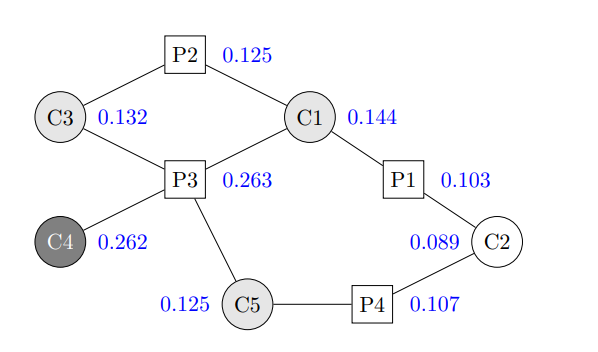

In [36]:
df['n2_ratioFraud'] = df['node'].apply(lambda x: generate_n2_ratioFraud(G, df, x))
df['n2_ratioNonFraud'] = df['node'].apply(lambda x: generate_n2_ratioNonFraud(G, df, x))
df['n2_binFraud'] = df['node'].apply(lambda x: generate_n2_binFraud(G, df, x))
df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size,n2_ratioFraud,n2_ratioNonFraud,n2_binFraud
0,P1,0.103355,0.102941,0.116519,0.143676,0.115826,0.124699,0.263114,2,3,2.333333,4.000000,0
1,P2,0.124699,0.134956,0.137863,0.143676,0.143295,0.183234,0.263114,2,2,3.500000,7.000000,0
2,P3,0.263114,0.130164,0.137863,0.261810,0.105155,0.106954,0.124699,4,3,4.000000,6.666667,0
3,P4,0.106954,0.098149,0.106935,0.124508,0.143295,0.183234,0.263114,2,2,3.500000,7.000000,0
4,C2,0.089363,0.104255,0.105155,0.106954,0.129300,0.134092,0.143676,2,2,0.000000,0.000000,1
5,C1,0.143676,0.114027,0.124699,0.263114,0.115722,0.128279,0.261810,3,4,0.250000,0.250000,1
6,C3,0.132049,0.159302,0.193906,0.263114,0.134092,0.143676,0.261810,2,3,0.333333,0.000000,1
7,C4,0.261810,0.263114,0.263114,0.263114,0.128279,0.132049,0.143676,1,3,0.000000,0.000000,1
8,C5,0.124508,0.145994,0.185034,0.263114,0.121378,0.137863,0.261810,2,4,0.250000,0.250000,1
